In [1]:
from flame_analysis_model import *
from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib as mpl
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


In [4]:
time_step = 235
phi = 0.40
lat_size = "200"
T_ref = 298
p_ref = 5e05

isolevels = [3, 3.5, 3.8, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.7]
n_isolevels = len(isolevels)

multiple_runs = True
n_RUN = 2

Soret_term = False
Soret_positive = False
post = True

rebuild_dataset = True

In [5]:
if (Soret_term & Soret_positive):
    folder_name = f"data/nek/phi{phi:.2f}/h400x{lat_size}_ref_Soret_positive"
    save_name = f"../data/isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret_positive"
elif Soret_term:
    folder_name = f"data/nek/phi{phi:.2f}/h400x{lat_size}_ref_Soret"
    save_name = f"../data/isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret"
else:
    folder_name = f"data/nek/phi{phi:.2f}/h400x{lat_size}_ref"
    save_name = f"../data/isocontours/phi{phi:.2f}/h400x{lat_size}_ref"
if multiple_runs:
    folder_name += f"/RUN0{n_RUN}"
    save_name += f"/RUN0{n_RUN}"
if post:
    file_name = "po_postPremix"
else:
    file_name = "premix"
if post:
    save_file_name = f"/extracted_flame_front_post_{time_step}.csv"
else:
    save_file_name = f"/extracted_flame_front_{time_step}.csv"

save_name_full = save_name + save_file_name

if rebuild_dataset:
    comm = MPI.COMM_WORLD
    rank = comm.rank

    # 2) Load dataset
    scalars = [
        'H2',  #s1
        'O2',  #s2
        'H2O',  #s3
        'H',  #s4
        'O',  #s5
        'OH',  #s6
        'HO2',  #s7
        'H2O2',  #s8
        'N2',  #s9
        'HRR',  #s10
        'curvature',  #s11
        'stretch_rate',  #s12
        'DW_FDS',  #s13
        'abs_flame_prop_vel_normal',  #s14
        'flow_velocity_normal',  #s15
        'flow_velocity_tangential',  #s16
        'strain_rate',  #s17
        'tangential_strain_rate',  #s18
        'normal_strain_rate',  #s19
        'density_ratio_sigma',  #s20
        'gradT',  #s21
        'gradT_normal',  #s22
        'total_heat_conduction'  #s23
    ]

    ds = SEMDataset(file_name=file_name, folder_name=folder_name, time_step=time_step, comm=MPI.COMM_WORLD,
                    scalar_names=scalars)

    df = ds.create_dataframe(
        compute_vel_jacobian=False,
        compute_vel_hessian=False,
        compute_reaction_rates=True,
        cantera_inputs=["../chemical_mech/BurkeH2.yaml", None, T_ref, p_ref]
    )

    df.to_csv(save_name_full, index=False)
else:
    df = pd.read_csv(save_name_full)

2025-12-10 17:06:48,954 - Mesh - INFO - Initializing empty Mesh object.
2025-12-10 17:06:48,954 - Field - INFO - Initializing empty Field object
2025-12-10 17:06:48,955 - pynekread - INFO - Reading file: ../data/phi0.40/h400x200_ref/RUN02/po_postPremix0.f00001
2025-12-10 17:06:49,057 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-12-10 17:06:49,057 - Mesh - INFO - Initializing common attributes.
2025-12-10 17:06:49,059 - Mesh - INFO - Getting vertices
2025-12-10 17:06:49,075 - Mesh - INFO - Getting edge centers
2025-12-10 17:06:49,234 - Mesh - INFO - Facet centers not available for 2D
2025-12-10 17:06:49,235 - Mesh - INFO - Mesh object initialized.
2025-12-10 17:06:49,236 - Mesh - INFO - Mesh data is of type: float64
2025-12-10 17:06:49,236 - Mesh - INFO - Elapsed time: 0.17956730001606047s
2025-12-10 17:06:49,237 - pynekread - INFO - Reading field data
2025-12-10 17:06:49,237 - pynekread - INFO - Overwriting fld object
2025-12-10 17:06:50,855 - pynekread - INFO - F

In [9]:
filter_min = 2.5
filter_max = 5
feature_setting = 0
n_clusters = 8

In [10]:
if feature_setting == 0:
    features = ['H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'T']
else:
    features = [
        'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
        'omega_HO2', 'omega_H2O2', 'HRR'
    ]
pipe = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    KMeans(n_clusters=n_clusters, init="k-means++", n_init=20,
           max_iter=300, random_state=0)
)
df = df[(df["x"] < 300)]
df = df[(df["T"] > filter_min) & (df["T"] < filter_max)]
X_raw = df[features].to_numpy()
labels = pipe.fit_predict(X_raw)

scaler = pipe.named_steps["standardscaler"]
centroids_scaled = pipe.named_steps["kmeans"].cluster_centers_
centroids_unscaled = scaler.inverse_transform(centroids_scaled)

X_scaled = scaler.transform(X_raw)

pca = PCA(n_components=None, random_state=0)
X2d = pca.fit_transform(X_scaled)
centroids2d = pca.transform(centroids_scaled)

loadings = pca.components_[:2, :]
contrib = loadings ** 2
contrib = contrib / contrib.sum(axis=1, keepdims=True)

C:\Users\alexp\AppData\Local\Temp\ipykernel_9376\1261032713.py:60: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



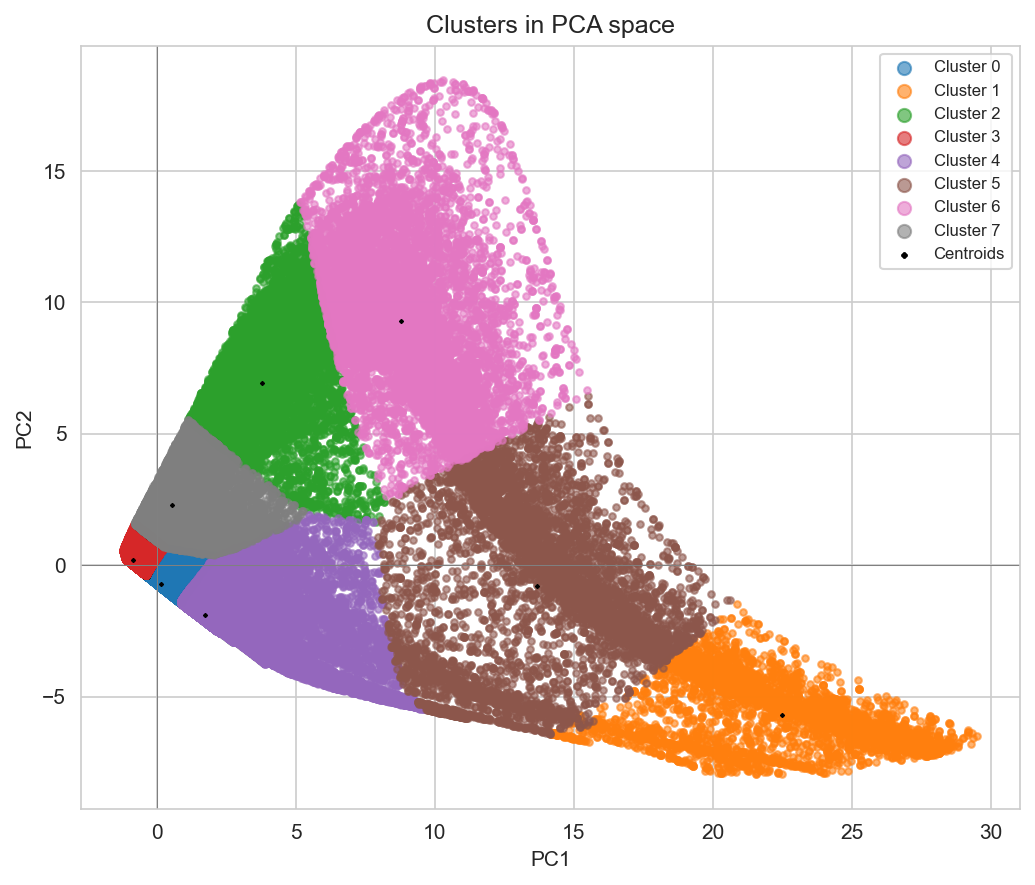

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



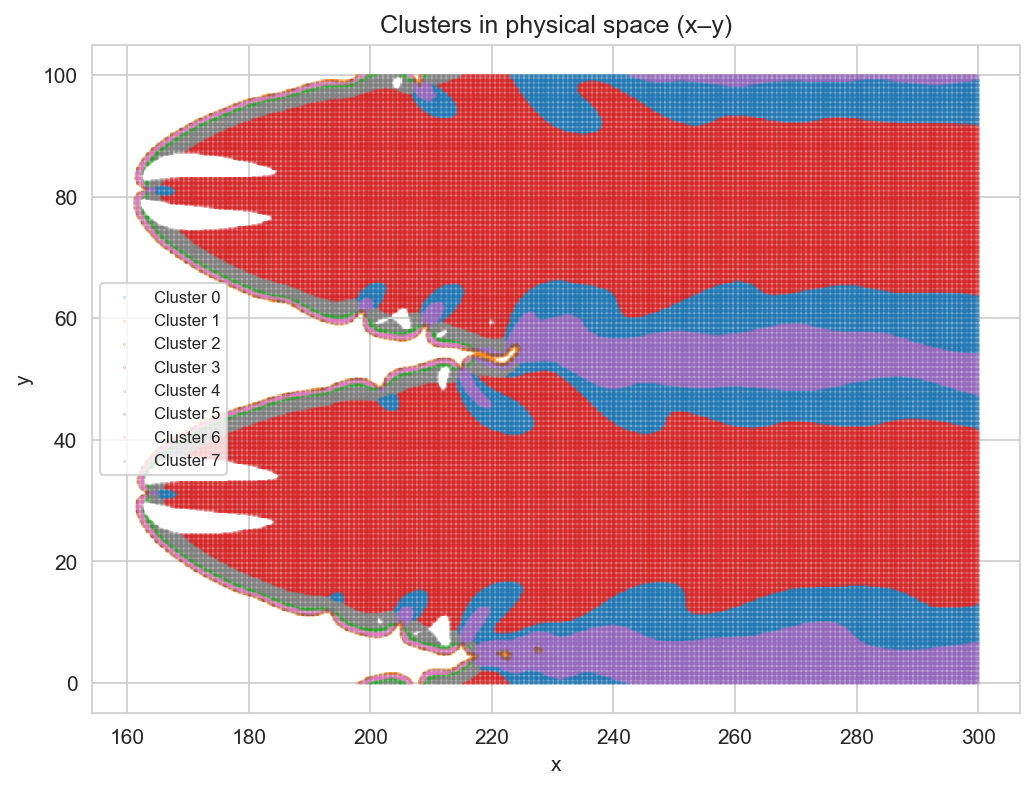

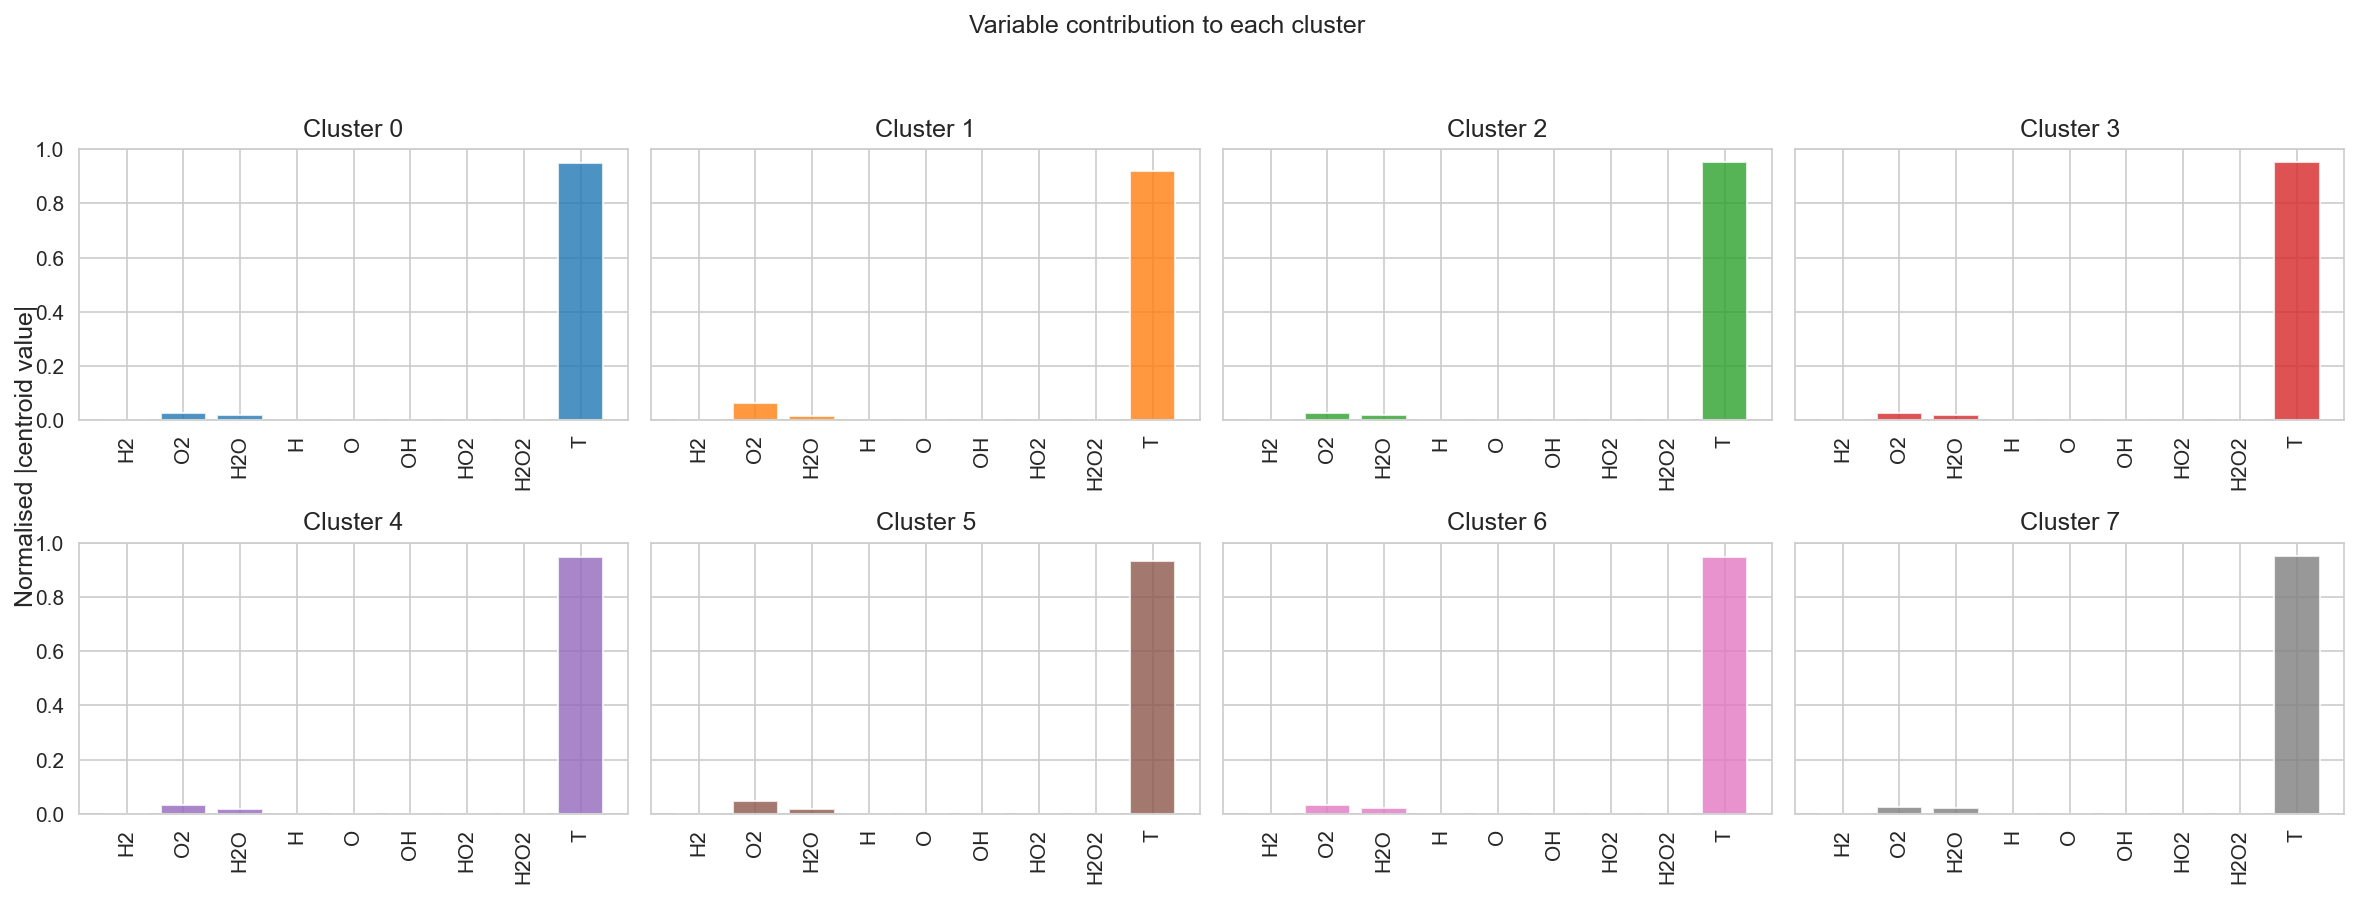

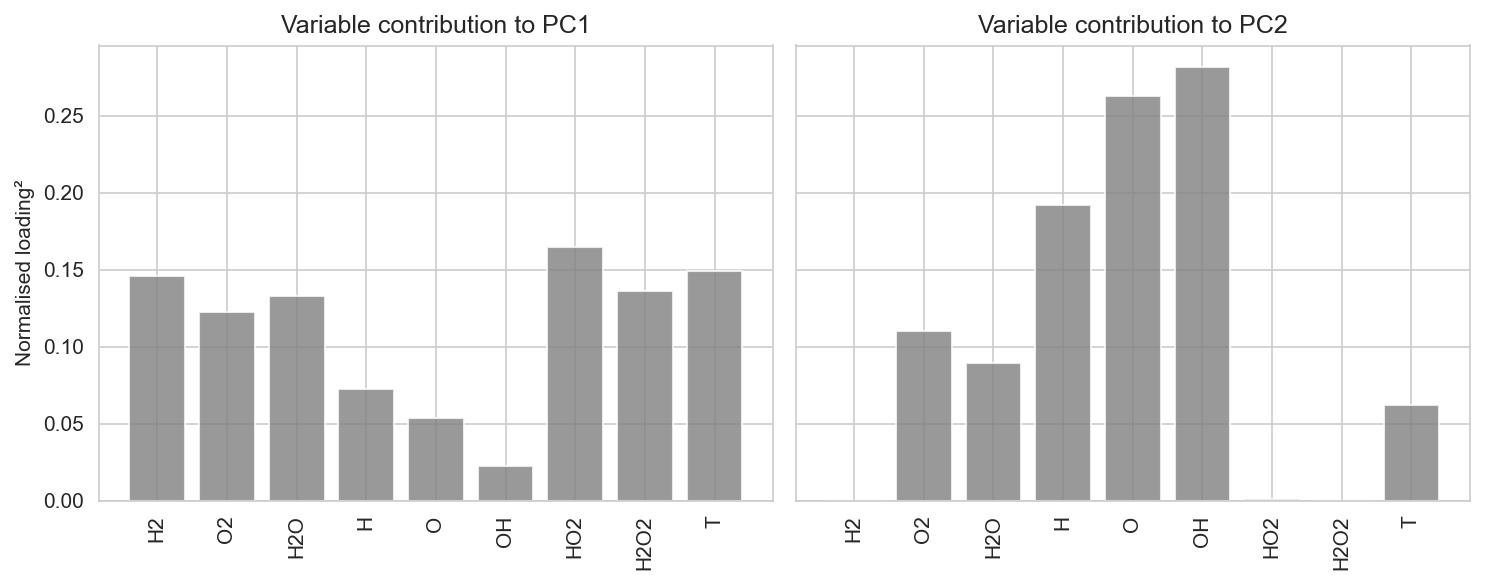

In [11]:
# -------------------------------------------------------------------
# 1) Clusters in PCA space (PC1 vs PC2)
# -------------------------------------------------------------------
fig_pca, ax_pca = plt.subplots(figsize=(7, 6), dpi=150)

cmap = mpl.colormaps["tab10"]
colors = [cmap(i) for i in range(n_clusters)]

for k in range(n_clusters):
    mask = (labels == k)
    ax_pca.scatter(
        X2d[mask, 0],
        X2d[mask, 1],
        s=10,
        color=colors[k],
        alpha=0.6,
        label=f"Cluster {k}",
    )

# cluster centroids in PCA space
ax_pca.scatter(
    centroids2d[:, 0],
    centroids2d[:, 1],
    s=1,
    color="black",
    marker="x",
    linewidths=2,
    label="Centroids",
)

ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")
ax_pca.set_title("Clusters in PCA space")
ax_pca.legend(markerscale=2, fontsize=8)
ax_pca.axhline(0, color="grey", linewidth=0.5)
ax_pca.axvline(0, color="grey", linewidth=0.5)
fig_pca.tight_layout()

# -------------------------------------------------------------------
# 2) Clusters in physical x–y space
# -------------------------------------------------------------------
fig_xy, ax_xy = plt.subplots(figsize=(7, 6), dpi=150)

for k in range(n_clusters):
    mask = (labels == k)
    ax_xy.scatter(
        df.loc[mask, "x"],
        df.loc[mask, "y"],
        s=0.01,
        color=colors[k],
        alpha=0.6,
        label=f"Cluster {k}",
    )

ax_xy.set_xlabel("x")
ax_xy.set_ylabel("y")
ax_xy.set_title("Clusters in physical space (x–y)")
ax_xy.set_aspect("equal", adjustable="box")
ax_xy.legend(markerscale=2, fontsize=8)
fig_xy.tight_layout()

# -------------------------------------------------------------------
# 3) Contribution of each variable to each cluster
#     -> normalised |centroid| per cluster
# -------------------------------------------------------------------
# absolute values then normalise per cluster so they sum to 1
cluster_contrib = np.abs(centroids_unscaled)
cluster_contrib_norm = cluster_contrib / cluster_contrib.sum(axis=1, keepdims=True)

n_features = len(features)
n_rows = 2
n_cols = int(np.ceil(n_clusters / n_rows))

fig_clust, axs_clust = plt.subplots(
    n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), dpi=150, sharey=True
)
axs_clust = np.atleast_2d(axs_clust)

for k in range(n_clusters):
    r = k // n_cols
    c = k % n_cols
    ax = axs_clust[r, c]

    ax.bar(
        np.arange(n_features),
        cluster_contrib_norm[k, :],
        color=colors[k],
        alpha=0.8,
    )
    ax.set_xticks(np.arange(n_features))
    ax.set_xticklabels(features, rotation=90)
    ax.set_title(f"Cluster {k}")

for idx in range(n_clusters, n_rows * n_cols):
    # hide any unused subplots
    r = idx // n_cols
    c = idx % n_cols
    axs_clust[r, c].axis("off")

fig_clust.supylabel("Normalised |centroid value|")
fig_clust.suptitle("Variable contribution to each cluster", y=0.99)
fig_clust.tight_layout(rect=[0, 0, 1, 0.95])

# -------------------------------------------------------------------
# 4) Contribution of each variable to PC1 and PC2
#     contrib already computed as squared loadings, normalised per PC
# -------------------------------------------------------------------
fig_pc, axs_pc = plt.subplots(1, 2, figsize=(10, 4), dpi=150, sharey=True)

pc_labels = ["PC1", "PC2"]
for i in range(2):
    ax = axs_pc[i]
    ax.bar(
        np.arange(n_features),
        contrib[i, :],
        color="grey",
        alpha=0.8,
    )
    ax.set_xticks(np.arange(n_features))
    ax.set_xticklabels(features, rotation=90)
    ax.set_title(f"Variable contribution to {pc_labels[i]}")

axs_pc[0].set_ylabel("Normalised loading²")
fig_pc.tight_layout()


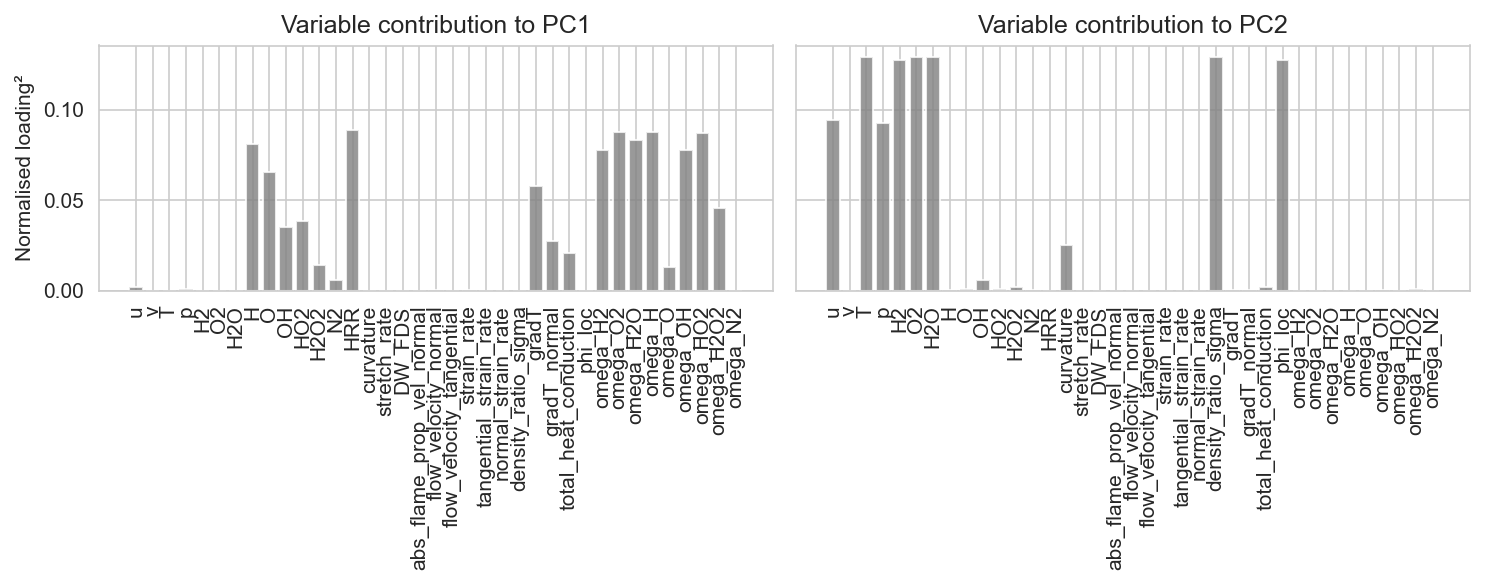

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 0) Use all columns except 'x' and 'y' as features
# -----------------------------------------------------------
features = [c for c in df.columns if c not in ["x", "y"]]
X_raw = df[features].to_numpy()            # shape (n_samples, n_features)

# Standardise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# -----------------------------------------------------------
# 1) PCA on selected features
# -----------------------------------------------------------
pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X_scaled)        # all PCs
X2d = X_pca[:, :2]                         # first two PCs for plotting

# Loadings: rows = PCs, columns = features
loadings = pca.components_

# -----------------------------------------------------------
# 2) Contribution of each feature to each PC
# -----------------------------------------------------------
contrib = loadings**2
contrib = contrib / contrib.sum(axis=1, keepdims=True)

# -----------------------------------------------------------
# 3) Plot contribution of each feature to PC1 and PC2
# -----------------------------------------------------------
n_features = len(features)
fig_pc, axs_pc = plt.subplots(1, 2, figsize=(10, 4), dpi=150, sharey=True)

pc_labels = ["PC1", "PC2"]
for i in range(2):
    ax = axs_pc[i]
    ax.bar(
        np.arange(n_features),
        contrib[i, :],
        color="grey",
        alpha=0.8,
    )
    ax.set_xticks(np.arange(n_features))
    ax.set_xticklabels(features, rotation=90)
    ax.set_title(f"Variable contribution to {pc_labels[i]}")

axs_pc[0].set_ylabel("Normalised loading²")
fig_pc.tight_layout()
plt.show()


Explained variance ratio per PC:
  PC1: 29.13%
  PC2: 21.14%
  PC3: 9.17%
  PC4: 8.33%
  PC5: 5.54%
  PC6: 5.30%
  PC7: 3.40%
  PC8: 2.79%
  PC9: 2.76%
  PC10: 2.42%
  PC11: 2.27%
  PC12: 2.17%
  PC13: 1.77%
  PC14: 1.46%
  PC15: 1.09%
  PC16: 0.44%
  PC17: 0.27%
  PC18: 0.19%
  PC19: 0.10%
  PC20: 0.09%
  PC21: 0.06%
  PC22: 0.05%
  PC23: 0.02%
  PC24: 0.01%
  PC25: 0.01%
  PC26: 0.00%
  PC27: 0.00%
  PC28: 0.00%
  PC29: 0.00%
  PC30: 0.00%
  PC31: 0.00%
  PC32: 0.00%
  PC33: 0.00%
  PC34: 0.00%
  PC35: 0.00%
  PC36: 0.00%
  PC37: 0.00%


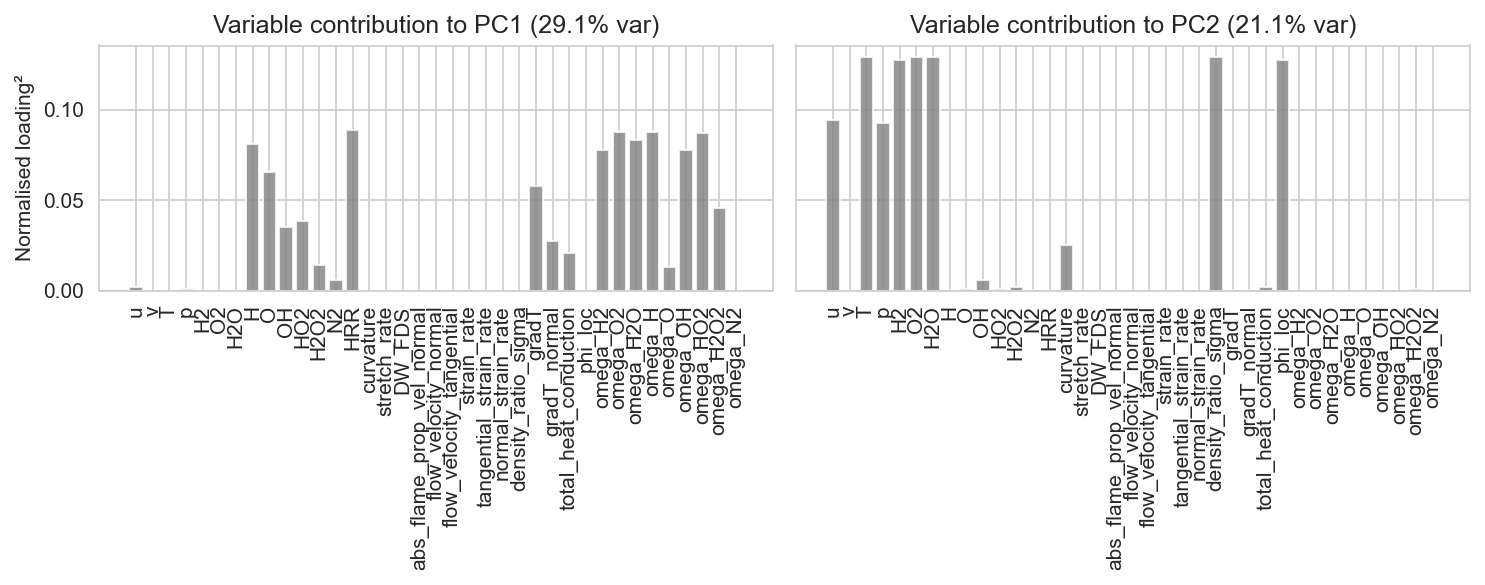

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 0) Use all columns except 'x' and 'y' as features
# -----------------------------------------------------------
features = [c for c in df.columns if c not in ["x", "y"]]
X_raw = df[features].to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# -----------------------------------------------------------
# 1) PCA
# -----------------------------------------------------------
pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X_scaled)      # all PCs
X2d = X_pca[:, :2]                       # keep for your scatter plots

loadings = pca.components_
expl_var_ratio = pca.explained_variance_ratio_   # fraction per PC

# Print variance explained by each component
print("Explained variance ratio per PC:")
for i, r in enumerate(expl_var_ratio):
    print(f"  PC{i+1}: {r*100:.2f}%")

# -----------------------------------------------------------
# 2) Feature contribution to each PC (loading², normalised)
# -----------------------------------------------------------
contrib = loadings**2
contrib = contrib / contrib.sum(axis=1, keepdims=True)

# -----------------------------------------------------------
# 3) Plot contributions for PC1 and PC2
# -----------------------------------------------------------
n_features = len(features)
fig_pc, axs_pc = plt.subplots(1, 2, figsize=(10, 4), dpi=150, sharey=True)

pc_labels = ["PC1", "PC2"]
for i in range(2):
    ax = axs_pc[i]
    ax.bar(
        np.arange(n_features),
        contrib[i, :],
        color="grey",
        alpha=0.8,
    )
    ax.set_xticks(np.arange(n_features))
    ax.set_xticklabels(features, rotation=90)
    ax.set_title(
        f"Variable contribution to {pc_labels[i]} "
        f"({expl_var_ratio[i]*100:.1f}% var)"
    )

axs_pc[0].set_ylabel("Normalised loading²")
fig_pc.tight_layout()
plt.show()

